# Plotting 
This notebook shows an example plot often used in this repository. This `openmc_fusion_benchmarks` provides a few classes that help plotting quickly results available in the `results_database` (e.g. `PlotReactionRates`, `PlotNuclearHeating` and `PlotEnergySpactra`). Objective of these classes is to plot values in an already precompiled format suitable for comparing results (all of the plots come with a subplot with compared absolute values - top subplot - and a C/E values - bottom subplot) and drastically reduce the line of codes in the `postprocessing.ipynb` notebooks.

In [1]:
import openmc_fusion_benchmarks as ofb
import matplotlib.pyplot as plt
import numpy as np

First we instantiate a couple of `ResultsFromDatabase` objects reading the hdf results file and we load the tally with the `get_tally_dataframe()` method (see the `read_database_hdffile.ipynb` notebook for more information). Example from the `fns_duct` benchmark.

In [2]:
# experimental results
experiment_file = ofb.ResultsFromDatabase(file='example_database/experiment.h5')
experiment_results = experiment_file.get_tally_dataframe(tally_name='rr_nb93')
# mcnp results 
mcnp_file = ofb.ResultsFromDatabase(file='example_database/mcnp-4b-c_fendl2.h5')
mcnp_results = mcnp_file.get_tally_dataframe(tally_name='rr_nb93')

We print the x-axis suggested:

In [3]:
xaxis = experiment_file.get_tally_xaxis(tally_name='rr_nb93')

xaxis

'Detector No.'

In this case we are plotting activation foils reaction rates coming from the `fns_duct` benchmark. 
To plot and compare the results we follow the steps below:
- Get the `xaxis` string like above (necessary to automatically retrieve the correct result DataFrame column as x-axis in the plot)
- Define an `ylabel` string (optional)
- Define additional info as string to print in the plot in `dtype_label` (optional)
- Instantiate a plot object with the `PlotReactionRates` class
- Plot the reference results with the `add_reference_results` method
- Plot as many other results as needed with the `add_computed_results` method

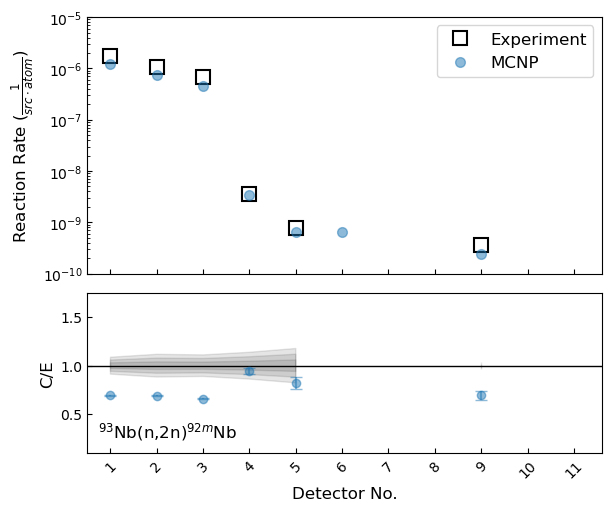

In [4]:
xaxis = experiment_file.get_tally_xaxis(tally_name='rr_nb93')  # get xaxis
ylabel = r'Reaction Rate $(\frac{1}{src \cdot atom})$'  # define ylabel
dtype_label = '$^{93}$Nb(n,2n)$^{92m}$Nb'  # define dtype_label
plot = ofb.PlotReactionRates(xaxis=xaxis, ylabel=ylabel, dtype_label=dtype_label)  # instantiate plot object
plot.add_reference_results(reference_data=experiment_results, label='Experiment')  # add reference results
plot.add_computed_results(computed_data=mcnp_results, marker='o', color='tab:blue', alpha=.5, label='MCNP')  # add computed results

Attention: there can be only one `add_reference_results` and it must be the first (it is the reference results, the denominator of the C/E values then), but there can be as many `add_computed_results` as we want. Usually the reference results is the measured one from the experiment but it does not need to be so. It is possible to use computed results if one want to do a pure code-to-code comparison. Also, if we don't want them to be the reference, measured results can be plotted with `add_computed_results` anyways since results coming from `results_database/` can be retrieved exactly in the samy way regardless of them being measured or computed.

Observe that the `ylabel` and the `dtype_label` arguments are not necessary because they just provide additional info for the plot. Namely, a string printed in the plot (here, the type of reaction) and the y-label for the absolute results (top subplots). Still, at least the definition of the `ylabel` is strongly recommended for clarity.

### Plotting Energy Spectra
In the case of plotting energy spectra the `PlotEnergySpectra' class initializes 4 subplots. The two on the top are absolute values while the two on the bottom are C/E values. The left plots have the energy axis (x-axis) in log-scale in order to better visualize the lower energie ranges while the right plots have a linear x-axis scale to better see the fast region.
This package provides additional functions to help visualize and compare energy spectra and make them suitable for the plotting class.
- The `rebin_spectrum` function rebins a spectra result (first argument) according to another energy structure provided as two lists of energy bounds (`energy_low` - second argument - and `energy_high` - third argument). Useful when the results to compare don't come with the same energy structure (necessary for the C/E computation)
- `rescale_to_lethargy(df: pd.DataFrame)` rescale the `mean` and `std. dev.` to the letargy.

These tools can be found in `utils.py` of the source code. The rest is consistent with the reaction rate example above.

Here an example from the `fns_duct` benchmark:

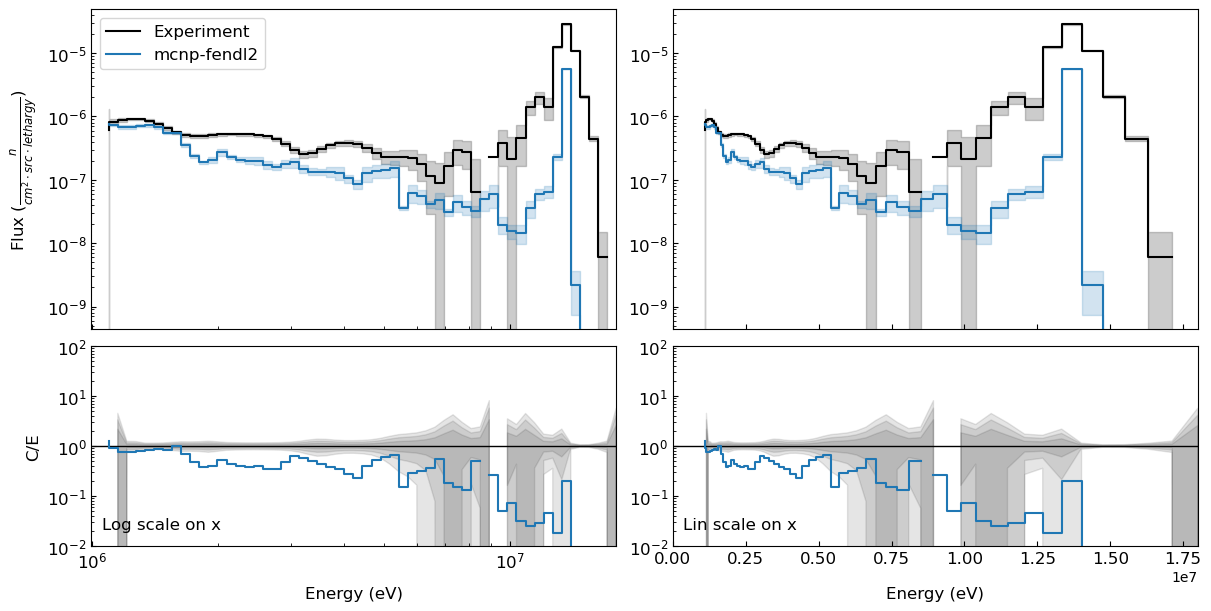

In [5]:
experiment_results = experiment_file.get_tally_dataframe(f'nspectrum_detector3')
mcnp_results = mcnp_file.get_tally_dataframe(f'nspectrum_detector3')

xaxis = experiment_file.get_tally_xaxis(tally_name='rr_nb93')  # get xaxis
ylabel = r'Flux $(\frac{n}{cm^2 \cdot src \cdot lethargy})$'  # define ylabel
dtype_label = 'Detector 3'  # define dtype_label

# plot
# preprocessing - rebin and rescale to lethargy
experiment_results = ofb.rescale_to_lethargy(experiment_results)
mcnp_results = ofb.rebin_spectrum(mcnp_results, experiment_results['energy low [eV]'], experiment_results['energy high [eV]'])
mcnp_results = ofb.rescale_to_lethargy(mcnp_results)

# generate figure
plot = ofb.PlotEnergySpectra(xaxis=xaxis, ylabel=ylabel, dtype_label=dtype_label)
plot.add_reference_results(reference_data=experiment_results, label='Experiment')
plot.add_computed_results(computed_data=mcnp_results, color='tab:blue', alpha=1, label='mcnp-fendl2')

Note that these plots can be slightly modified by using their `matplotlib.axes` object.
Example:

(0.0001, 10000.0)

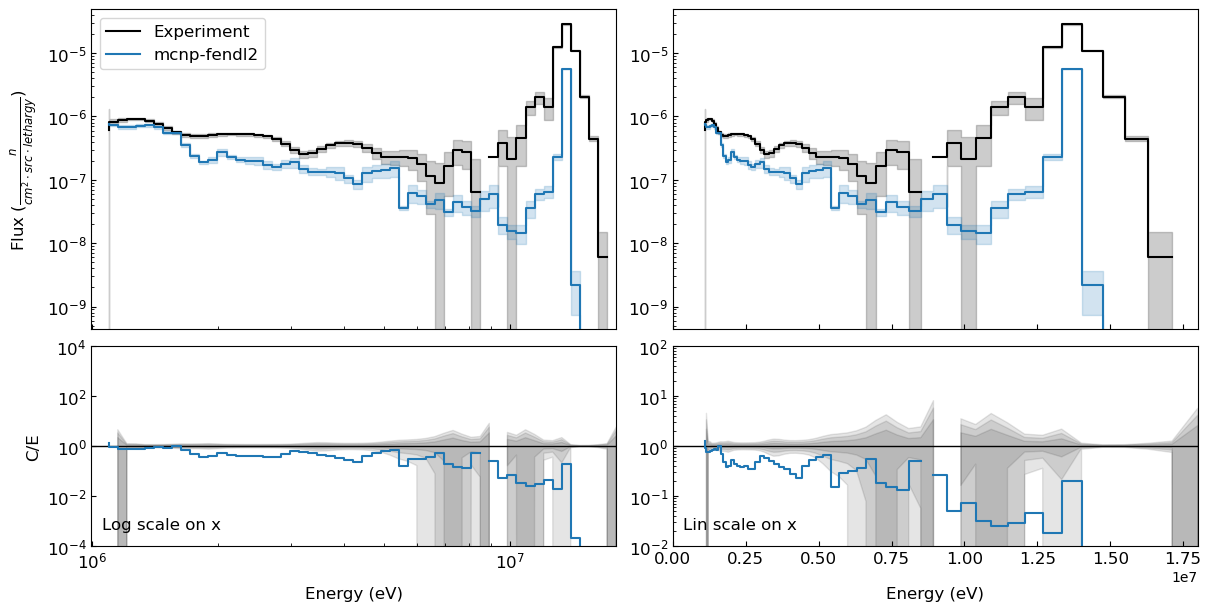

In [6]:
# generate figure
plot = ofb.PlotEnergySpectra(xaxis=xaxis, ylabel=ylabel, dtype_label=dtype_label)
plot.add_reference_results(reference_data=experiment_results, label='Experiment')
plot.add_computed_results(computed_data=mcnp_results, color='tab:blue', alpha=1, label='mcnp-fendl2')

# change the ylims of the bottom left plot
plot.ax[1][0].set_ylim(1e-4, 1e4)

### More tools for visualization
This package provides in the a couple of tools that help adding visualization features (see `visualization.py` file for more information). 
- One is the `get_floor_ceiling()` function. It authomatically frames the plot on the y-axis by finding the min and max values of the dataset to plot or their min and max order of magnitudes depending if the plot has either a linear or a logarithmic y scale (the function takes in either an array of values or a list of arrays in order to be able to check the max and min of multiple arrays superimposed on the same plot)
- Another feature is the `plot_stddev_area()` function. It plots the errorbars of the dataset as shaded areas and can account for 1,2 or 3 std. dev. depending on the precision wanted


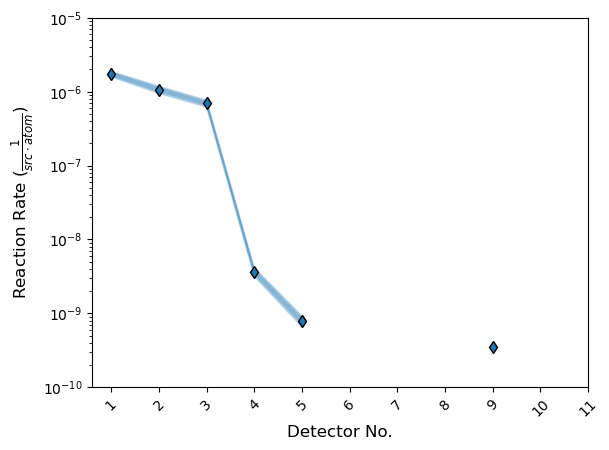

In [7]:
experiment_results = experiment_file.get_tally_dataframe(tally_name='rr_nb93')

tickers = np.arange(len(experiment_results['mean']))

fig, ax = plt.subplots()
ofb.add_floor_ceiling(ax=ax, values=experiment_results['mean'], scale='log', gap=0)
ofb.plot_stddev_area(ax=ax, ticks=tickers, mean=experiment_results['mean'], std_dev=experiment_results['std. dev.'],
                     color='tab:blue', alpha=.2, uncertainty_deg=3)
ax.plot(tickers, experiment_results['mean'], marker='d', mec='k', ls='', color='tab:blue')
ax.set_xticks(tickers)
ax.set_xticklabels(experiment_results[xaxis])
ax.tick_params(axis='x', labelrotation=45)
ax.set_xlabel(xaxis, fontsize=12)
ax.set_ylabel(r'Reaction Rate $(\frac{1}{src \cdot atom})$', fontsize=12)
ax.set_yscale('log')

plt.show()